In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.path import Path

import pickle
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import cat
from torchvision import transforms
from sklearn.utils import gen_batches

# Data Importation and Treatment

In [14]:
# Importation of the data
filename = './data/meta_data.hdf'
row_data = pd.read_hdf(filename,'/d')

print(f'There are {row_data.shape[0]} observations and each observation has {row_data.shape[1]} attributes.')

There are 37779 observations and each observation has 7 attributes.


In [15]:
# Here we merge all data (csv) together from the validation part 
all_files = ['paths_df_validated_3000_5500.csv', 'paths_df_validated_5500_6500.csv']
final_data = pd.DataFrame()

for file in all_files : 
    temp = pd.read_csv(file)
    temp = temp.loc[temp['valid'] == True] #Select only the 'True' = Validated images
    final_data = pd.concat([final_data,temp],axis=0) #Concatenate the information in one dataframe

# We select the images from row_data with the index of the validation part (final_data)
index_name = final_data['original_index'].values    # Select the index
data = row_data.iloc[index_name]                    # Extract the validated images

print(f'There are {data.shape[0]} validated observations and each observation has {data.shape[1]} attributes.')

There are 1620 validated observations and each observation has 7 attributes.


In [16]:
# This bloc checks if the selected images are the good ones
n_match = (final_data['mask_path'].values == data['building_id'].values).sum()
if n_match == data.shape[0] :
    print('All is good with the dataset, we can continue !')
else : 
    print('There is a mismatch between pictures (pictures names)')

All is good with the dataset, we can continue !


In [17]:
# This bloc plots the picture and the corresponding polygon surfaces.
showing = False 

# This function plots the surface polygons of the selected image 
def image_reader (image_data) : 
    surfaces = image_data.b_surfaces
    # One polygone
    if (len(surfaces[0])==2) : 
        plt.plot(np.array(surfaces)[:,1],np.array(surfaces)[:,0], label = 'surface', c = 'r')
    # Multiples polygones
    else :
        for polygons in surfaces : 
            plt.plot(np.array(polygons)[:,1],np.array(polygons)[:,0], label = 'surface', c = 'r')
    return 0

# The for-loop that will plot the pictures 
if showing :
    n = 1
    for i in range (n) : 
        a = data.iloc[i]
        im_name = a.building_id +  '-b15-otovowms.jpeg'
        print(im_name)
        im_matrix = plt.imread('./data/' + im_name)
        plt.imshow(im_matrix)
        image_reader(a)
        plt.show()

In [18]:
# This function creates the mask for one image, the mask is a array (500*500)
def mask_creation (n,p,surfaces) : 
    # If one polygon in surface list
    if (len(surfaces[0])==2) : 
        x, y = np.meshgrid(np.arange(n), np.arange(p))
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T
        path = Path(surfaces)
        grid = path.contains_points(points)
        grid = grid.reshape((n,p))
    # If multiple polygones in surface list
    else :
        grid = np.reshape([False for i in range (n*p)],(n,p))
        for i,polygons in enumerate(surfaces) : 
            x, y = np.meshgrid(np.arange(n), np.arange(p))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(polygons)
            grid_2 = path.contains_points(points)
            grid_2 = grid_2.reshape((n,p))
            grid = np.add(grid,grid_2)
    # We return the 500*500 matrix filled with True and False
    return (grid)



# This function creates a format that will be use for the DL Network
def creation_useful_dataset(dataset) : 
    # Creation of variables 
    X=[]; Y=[];
    length,_ = dataset.shape
    n = 500; p = 500; # Image Shape
    for i in tqdm(range(length)) :
        # Import the wanted picture and the matrix
        info = dataset.iloc[i]
        image_name = info.building_id + '-b15-otovowms.jpeg'
        im_matrix = plt.imread('./data/' + image_name)
        # We build the X_dataset 
        X.append(im_matrix)
        # We build the target_dataset
        surfaces = info.b_surfaces
        Y.append(mask_creation(n,p,surfaces))
    # We convert the array in pytorch Tensor 
    X = torch.Tensor(np.array(X))
    X = torch.swapaxes(X, 1, -1)  # To have (B,C,H,W)
    Y = torch.Tensor(np.array(Y)) 
    return (X,Y)

In [14]:
# We create a split 70% Training set, 15% validation set, 15% testing set 
n_split1 = int(data.shape[0]*0.70) 
n_split2 = int(data.shape[0]*0.85)
df_train = data.iloc[:n_split1]
df_validation = data.iloc[n_split1:n_split2]
df_test = data.iloc[n_split2:]

print('Importation of the Training set')
X_train, Y_train = creation_useful_dataset(df_train)
print('Importation of the Validation set')
X_validation, Y_validation = creation_useful_dataset(df_train)
print('Importation of the Testing set')
X_test, Y_test = creation_useful_dataset(df_test)

Importation of the Training set


100%|███████████████████████████████████████| 1296/1296 [02:16<00:00,  9.47it/s]


Importation of the Testing set


100%|█████████████████████████████████████████| 324/324 [00:33<00:00,  9.66it/s]


In [ ]:
# Dump the data into a pickle file
with open('./pickles/data.X_train', 'wb') as f:
     pickle.dump(X_train, f)
with open('./pickles/data.Y_train', 'wb') as f:
     pickle.dump(Y_train, f)
        
with open('./pickles/data.X_validation', 'wb') as f:
     pickle.dump(X_validation, f)
with open('./pickles/data.Y_validation', 'wb') as f:
     pickle.dump(Y_validation, f)
with open('./pickles/data.X_test', 'wb') as f:
     pickle.dump(X_test, f)
with open('./pickles/data.Y_test', 'wb') as f:
     pickle.dump(Y_test, f)

**Data Augmentation** 

We can shift the image 90°,180°,270° to have more images to train on.

# Deep Learning Network 

In [3]:
# Load the data from a pickle file
with open('./pickles/data.X_train', 'rb') as f:
     X_train = pickle.load(f)
with open('./pickles/data.Y_train', 'rb') as f:
     Y_train = pickle.load(f)
with open('./pickles/data.X_validation', 'rb') as f:
     X_validation = pickle.load(f)
with open('./pickles/data.Y_validation', 'rb') as f:
     Y_validation = pickle.load(f)
with open('./pickles/data.X_test', 'rb') as f:
     X_test = pickle.load(f)
with open('./pickles/data.Y_test', 'rb') as f:
     Y_test = pickle.load(f)

In [10]:
print(f'X_train : {X_train.shape} - [Batchsize,Channel,Height,Width]')
print(f'Y_train : {Y_train.shape} - [Batchsize,Height,Width]')
print(f'X_validation : {X_validation.shape} - [Batchsize,Channel,Height,Width]')
print(f'Y_validation : {Y_validation.shape} - [Batchsize,Height,Width]')
print(f'X_test : {X_test.shape} - [Batchsize,Channel,Height,Width]')
print(f'Y_test : {Y_test.shape} - [Batchsize,Height,Width]')

X_train : torch.Size([1296, 3, 500, 500]) - [Batchsize,Channel,Height,Width]
Y_train : torch.Size([1296, 500, 500]) - [Batchsize,Height,Width]
X_validation : torch.Size([75, 3, 500, 500]) - [Batchsize,Channel,Height,Width]
Y_validation : torch.Size([75, 500, 500]) - [Batchsize,Height,Width]
X_test : torch.Size([24, 3, 500, 500]) - [Batchsize,Channel,Height,Width]
Y_test : torch.Size([24, 500, 500]) - [Batchsize,Height,Width]


In [36]:
small_dataset_for_test = False 

## For testing the network, we take a smaller dataset 
if small_dataset_for_test : 
    n_split = 3
    df_train = data.iloc[:n_split]
    df_validation = data.iloc[n_split:n_split+2]
    df_test = data.iloc[n_split+2:n_split+4]
    print('Importation of the Training set')
    X_train, Y_train = creation_useful_dataset(df_train)
    print('Importation of the Validation set')
    X_validation, Y_validation = creation_useful_dataset(df_validation)
    print('Importation of the Testing set')
    X_test, Y_test = creation_useful_dataset(df_test)

In [30]:
# The convolutional network (U-net)
class UNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Contracting Path
        self.conv11 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv21 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv31 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv41 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.conv42 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv51 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3, stride=1, padding=1)
        self.conv52 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)

        # Expanding Path
        self.up5 = nn.Upsample(size=(62,62))
        self.conv53 = nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.conv61 = nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.conv62 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.up6 = nn.Upsample(size=(125,125))
        self.conv63 = nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.conv71 = nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.conv72 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.up7 = nn.Upsample(size=(250,250))
        self.conv73 = nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.conv81 = nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.conv82 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.up8 = nn.Upsample(size=(500,500))
        self.conv83 = nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv91 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.conv92 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.conv93 = nn.Conv2d(in_channels=64,out_channels=2,kernel_size=3, stride=1, padding=1)

        # Output
        self.conv10 = nn.Conv2d(in_channels=2,out_channels=1,kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = F.relu(self.conv11(x))
        x1 = F.relu(self.conv12(x1))
        
        x2 = self.pool1(x1)
        x2 = F.relu(self.conv21(x2))
        x2 = F.relu(self.conv22(x2))
        
        x3 = self.pool2(x2)
        x3 = F.relu(self.conv31(x3))
        x3 = F.relu(self.conv32(x3))
        
        x4 = self.pool3(x3)
        x4 = F.relu(self.conv41(x4))
        x4 = F.relu(self.conv42(x4))
        
        x5 = self.pool4(x4)
        x5 = F.relu(self.conv51(x5))
        x5 = F.relu(self.conv52(x5))

        # Expanding Path
        x5 = self.up5(x5)
        x6 = self.conv53(x5)
        x4 = transforms.CenterCrop(62)(x4)
        x6 = cat([x4, x6], axis=1)
        x6 = F.relu(self.conv61(x6))
        x6 = F.relu(self.conv62(x6))
        
        x6 = self.up6(x6)
        x7 = self.conv63(x6)
        x3 = transforms.CenterCrop(125)(x3)
        x7 = cat([x3, x7], axis=1)
        x7 = F.relu(self.conv71(x7))
        x7 = F.relu(self.conv72(x7))
        
        x7 = self.up7(x7)
        x8 = self.conv73(x7)
        x2 = transforms.CenterCrop(250)(x2)
        x8 = cat([x2, x8], axis=1)
        x8 = F.relu(self.conv81(x8))
        x8 = F.relu(self.conv82(x8))
        
        x8 = self.up8(x8)
        x9 = self.conv83(x8)
        x1 = transforms.CenterCrop(500)(x1)
        x9 = cat([x1, x9], axis=1)      
        x9 = F.relu(self.conv91(x9))
        x9 = F.relu(self.conv92(x9))
        x9 = F.relu(self.conv93(x9))

        # Output
        x10 = self.conv10(x9)
        x10 = torch.sigmoid(x10)
        return x10

In [31]:
class UNetV3(nn.Module):
    def __init__(self):
        super().__init__()
        # Contracting Path
        self.conv11 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3, stride=1, padding=1)        
        self.bn11 = nn.BatchNorm2d(num_features = 64, eps = 0.00001, momentum = 0.1)
        self.conv12 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.bn12 = nn.BatchNorm2d(num_features = 64, eps = 0.00001, momentum = 0.1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv21 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.bn21 = nn.BatchNorm2d(num_features = 128, eps = 0.00001, momentum = 0.1)
        self.conv22 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.bn22 = nn.BatchNorm2d(num_features = 128, eps = 0.00001, momentum = 0.1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv31 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.bn31 = nn.BatchNorm2d(num_features = 256, eps = 0.00001, momentum = 0.1)
        self.conv32 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.bn32 = nn.BatchNorm2d(num_features = 256, eps = 0.00001, momentum = 0.1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv41 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.bn41 = nn.BatchNorm2d(num_features = 512, eps = 0.00001, momentum = 0.1)
        self.conv42 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.bn42 = nn.BatchNorm2d(num_features = 512, eps = 0.00001, momentum = 0.1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv51 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3, stride=1, padding=1)
        self.bn51 = nn.BatchNorm2d(num_features = 1024, eps = 0.00001, momentum = 0.1)
        self.conv52 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3, stride=1, padding=1)
        self.bn52 = nn.BatchNorm2d(num_features = 1024, eps = 0.00001, momentum = 0.1)
        self.pool5 = nn.MaxPool2d(2, 2)

        # Expanding Path
        self.up5 = nn.Upsample(size=(62,62))
        self.conv53 = nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn53 = nn.BatchNorm2d(num_features = 512, eps = 0.00001, momentum = 0.1)
        
        self.conv61 = nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.bn61 = nn.BatchNorm2d(num_features = 512, eps = 0.00001, momentum = 0.1)
        self.conv62 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.bn62 = nn.BatchNorm2d(num_features = 512, eps = 0.00001, momentum = 0.1)
        self.up6 = nn.Upsample(size=(125,125))
        self.conv63 = nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn63 = nn.BatchNorm2d(num_features = 256, eps = 0.00001, momentum = 0.1)

        self.conv71 = nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.bn71 = nn.BatchNorm2d(num_features = 256, eps = 0.00001, momentum = 0.1)
        self.conv72 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.bn72 = nn.BatchNorm2d(num_features = 256, eps = 0.00001, momentum = 0.1)
        self.up7 = nn.Upsample(size=(250,250))
        self.conv73 = nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn73 = nn.BatchNorm2d(num_features = 128, eps = 0.00001, momentum = 0.1)
        
        self.conv81 = nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.bn81 = nn.BatchNorm2d(num_features = 128, eps = 0.00001, momentum = 0.1)
        self.conv82 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.bn82 = nn.BatchNorm2d(num_features = 128, eps = 0.00001, momentum = 0.1)
        self.up8 = nn.Upsample(size=(500,500))
        self.conv83 = nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn83 = nn.BatchNorm2d(num_features = 64, eps = 0.00001, momentum = 0.1)
        
        self.conv91 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.bn91 = nn.BatchNorm2d(num_features = 64, eps = 0.00001, momentum = 0.1)
        self.conv92 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.bn92 = nn.BatchNorm2d(num_features = 64, eps = 0.00001, momentum = 0.1)
        self.conv93 = nn.Conv2d(in_channels=64,out_channels=2,kernel_size=3, stride=1, padding=1)
        self.bn93 = nn.BatchNorm2d(num_features = 2, eps = 0.00001, momentum = 0.1)

        # Output
        self.conv10 = nn.Conv2d(in_channels=2,out_channels=1,kernel_size=1)
        self.bn10 = nn.BatchNorm2d(num_features = 1, eps = 0.00001, momentum = 0.1)
        
        # The Dropout Rate of the Network
        self.dropout = nn.Dropout(0.2) 

    def forward(self, x):
        # Contracting Path
        x1 = F.relu(self.bn11(self.conv11(x)))
        x1 = F.relu(self.bn12(self.conv12(x1)))
        x1 = self.pool1(x1)
        x2 = self.dropout(x1)
        
        x2 = F.relu(self.bn21(self.conv21(x2)))
        x2 = F.relu(self.bn22(self.conv22(x2)))
        x2 = self.pool2(x2)
        x3 = self.dropout(x2)
        
        x3 = F.relu(self.bn31(self.conv31(x3)))
        x3 = F.relu(self.bn32(self.conv32(x3)))
        x3 = self.pool3(x3)
        x4 = self.dropout(x3)
        
        x4 = F.relu(self.bn41(self.conv41(x4)))
        x4 = F.relu(self.bn42(self.conv42(x4)))
        x4 = self.pool4(x4)
        x5 = self.dropout(x4)
        
        x5 = F.relu(self.bn51(self.conv51(x5)))
        x5 = F.relu(self.bn52(self.conv52(x5)))

        # Expanding Path
        x5 = self.up5(x5)
        x6 = self.bn53(self.conv53(x5))
        x4 = transforms.CenterCrop(62)(x4)
        x6 = cat([x4, x6], axis=1)
        x6 = self.dropout(x6)
        x6 = F.relu(self.bn61(self.conv61(x6)))
        x6 = F.relu(self.bn62(self.conv62(x6)))
        
        x6 = self.up6(x6)
        x7 = self.bn63(self.conv63(x6))
        x3 = transforms.CenterCrop(125)(x3)
        x7 = cat([x3, x7], axis=1)
        x7 = self.dropout(x7)
        x7 = F.relu(self.bn71(self.conv71(x7)))
        x7 = F.relu(self.bn72(self.conv72(x7)))
        
        x7 = self.up7(x7)
        x8 = self.bn73(self.conv73(x7))
        x2 = transforms.CenterCrop(250)(x2)
        x8 = cat([x2, x8], axis=1)
        x8 = self.dropout(x8)
        x8 = F.relu(self.bn81(self.conv81(x8)))
        x8 = F.relu(self.bn82(self.conv82(x8)))
        
        x8 = self.up8(x8)
        x9 = self.bn83(self.conv83(x8))
        x1 = transforms.CenterCrop(500)(x1)
        x9 = cat([x1, x9], axis=1)      
        x9 = self.dropout(x9)
        x9 = F.relu(self.bn91(self.conv91(x9)))
        x9 = F.relu(self.bn92(self.conv92(x9)))
        x9 = F.relu(self.bn93(self.conv93(x9)))

        # Output
        x10 = self.bn10(self.conv10(x9))
        x10 = torch.sigmoid(x10)
        return x10

In [32]:
# The loss function : Intersection over Union (IoU)
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        # Intersection is equivalent to True Positive count
        # Union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        IoU = (intersection + smooth)/(union + smooth)
        return 1 - IoU

Model n°0
   Epoch n°1/1


100%|█████████████████████████████████████████████| 2/2 [01:06<00:00, 33.34s/it]


 Model 1 Trained and pickled
Model n°1
   Epoch n°1/1


100%|█████████████████████████████████████████████| 2/2 [01:29<00:00, 44.78s/it]


 Model 2 Trained and pickled


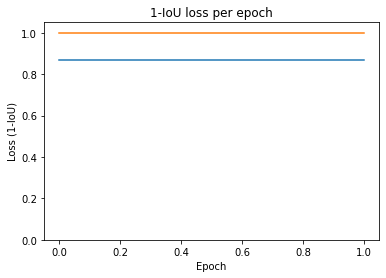

In [35]:
# Settings of the model 
net1 = UNetV2()      # Simple model
net2 = UNetV3()     # Model with dropout and BatchNorm2d
criterion = IoULoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6)
models = [net1,net2]

# Batch Creation for the training of the model
batch_size = 2
batches_index_train = list(gen_batches(X_train.shape[0],batch_size=batch_size))
n_epoch = 1

for j,net in enumerate(models) : 
    # Someful paramaters 
    losses_values_per_batches = []
    print(f'Model n°{j}')
    for epoch in range(n_epoch) : # loop over the dataset multiple times
        print(f'   Epoch n°{epoch+1}/{n_epoch}')
        for i in tqdm(range(len(batches_index_train))) : 
            batch_slice = batches_index_train[i]                         # Get the index of the batch
            inputs, masks = X_train[batch_slice], Y_train[batch_slice]   # Get inputs and masks
            # zero the parameter gradients
            optimizer.zero_grad()
            # Step : forward + backward + optimize
            outputs = torch.squeeze(net(inputs),dim=1)     # To reduce the dimension to [B,H,W] of outputs
            outputs = (outputs>0.5)*1                      # From probabilities to [0,1] for mask and loss computation
            # Computation of loss function
            loss = criterion(outputs, masks)               # Compute 1-IoT as loss value 
            loss.requires_grad = True                      # We add a gradient to the loss tensor
            loss.backward()                                # Backward of loss function
            optimizer.step()                               # We optimize the network

            ## We compute loss for this batch on the validation set
            net.eval()                                     # We want to evaluate the model
            inputs, masks = X_validation, Y_validation     # Get the inputs and masks of validation set 
            outputs = torch.squeeze(net(inputs),dim=1)>0.5 # Output of the model    
            loss = criterion((outputs), masks)             # Compute 1-IoT as loss value 
            losses_values_per_batches.append(loss.mean())  # Append the mean loss of the batch 
            net.train()                                    # We turn the model to training mode 
    
    if(j == 0) : # If net1 == U_netV2
        # Pickle the model 
        with open('./pickles/cnn_model', 'wb') as f:
             pickle.dump(net, f)

        print('   Model 1 Trained and pickled /n')

        # We create a plot/png of the loss of the model for epoch batch 
        plt.plot(range(len(batches_index_train)*n_epoch),losses_values_per_batches)
        plt.title('1-IoU loss per epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (1-IoU)')
        plt.ylim(0,1.05)
        plt.savefig('./pickles/graph_loss_per_batch.png')
    
    if(j == 1) : # If net2 == U_netV3
        # Pickle the model 
        with open('./pickles/cnn_model_improved', 'wb') as f:
             pickle.dump(net, f)

        print('   Model 2 Trained and pickled /n')

        # We create a plot/png of the loss of the model for epoch batch 
        plt.plot(range(len(batches_index_train)*n_epoch),losses_values_per_batches)
        plt.title('1-IoU loss per epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (1-IoU)')
        plt.ylim(0,1.05)
        plt.savefig('./pickles/graph_loss_per_batch_improved.png')


# Importation of the DL network

In [127]:
# Pickle the model 
with open('./pickles/cnn_model', 'rb') as f:
     net = pickle.load(f)
with open('./pickles/cnn_model_improved', 'rb') as f:
     net_improved = pickle.load(f)

In [128]:
# Testing the model 
outputs = torch.squeeze(net(X_test),dim=1)
outputs = (outputs>0.5)
print(f'The loss is : {criterion(outputs, Y_test)}')

The loss is : 0.8936958312988281


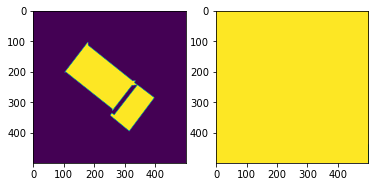

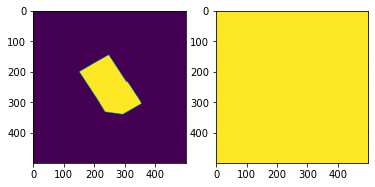

In [129]:
# Plotting for rigolade 
for i, prediction in enumerate(outputs[:3]) :
    fig,ax = plt.subplots(1,2)
    true_mask = np.array(Y_test[i])
    prediction = np.array(prediction)
    ax[0].imshow(true_mask)
    ax[1].imshow(prediction)
    plt.show()

# To do list :

**Optimizer :** We can try with different optimizers to see some differences.

**Batch :** Export and Import batch data for each epoch to use less memory.

**Metrics :** We can use intersection over union (IoU) with the masks, AUC, position recall curve.

**Expansion of the model :** We can test the model on unseen data to see if it can be generalized.

**Create a validation set :** In order to validate of model for each epoch, we can compute the loss withthe validation set.